#Retinal Disease Classifier using OCT imaging and pretrained ViT model

* Dataset: https://www.kaggle.com/datasets/paultimothymooney/kermany2018
* Model: https://huggingface.co/docs/transformers/model_doc/vit?usage=Pipeline



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import os
import zipfile #for zip file
import tarfile #for .tar.gz file
from tqdm.notebook import tqdm

# Imports for Class Activation Maps (CAM)
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Check if CUDA is available and print the GPU name
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
else:
    print("CUDA is not available. Using CPU.")
torch.cuda.get_device_name(0)

CUDA is available. Using GPU.


'NVIDIA GeForce GTX 1650 Ti'

In [16]:
class config:
    lr = 0.0005
    batch_size = 8
    num_epochs = 5
    image_size = 224
    num_classes = 4
    model_name = 'vit_tiny_patch16_224'
    #model_name = 'vit_base_patch16_224'

In [6]:
#Crete a directory for saving results
output = 'results'
if not os.path.exists(output):
    os.makedirs(output)

In [7]:
#create a directory for dataset
dataset_dir = 'dataset'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

In [8]:
# Extract the dataset if it's in a zip file
zip_file_path = 'dataset/OCT2017.zip'  # Path to your zip file
extract_dir = 'dataset'        # Directory to extract to

if os.path.exists(zip_file_path):
    print(f"Extracting {zip_file_path} to {extract_dir} ...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction complete.")
else:
    print(f"Zip file {zip_file_path} does not exist.")

Extracting dataset/OCT2017.zip to dataset ...


KeyboardInterrupt: 

In [23]:
# define paths to the image folders for train and test
base_image_path = 'dataset/OCT2017Subset'
train_dir = os.path.join(base_image_path, 'train')
test_dir = os.path.join(base_image_path, 'test')

In [24]:
#define the data transformations
train_transforms = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
#create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)
# Load the pre-trained model

In [26]:
#how many train and test images in dataset
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")


Number of training images: 1000
Number of testing images: 232


In [27]:
# Load the pre-trained model
model = timm.create_model(config.model_name, 
                          pretrained=True, 
                          num_classes=config.num_classes)
model = model.to(device)

In [28]:
#loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.lr)


In [29]:
#Training loop
for epoch in range(config.num_epochs):
    print(f"Epoch {epoch+1}/{config.num_epochs}")
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Free up memory
        del images, labels, outputs
        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1/5
Loss: 1.2246, Accuracy: 0.4740
Epoch 2/5
Loss: 0.6884, Accuracy: 0.7180
Epoch 3/5
Loss: 0.6293, Accuracy: 0.7580
Epoch 4/5
Loss: 0.5658, Accuracy: 0.7840
Epoch 5/5
Loss: 0.3903, Accuracy: 0.8560


In [32]:
#Evaluation loop
model.eval()
all_labels = []
all_preds = []
all_probs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Get probabilities for ROC/PR curves
        probs = torch.nn.functional.softmax(outputs, dim=1)

        # Get final predictions for confusion matrix
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

In [34]:
#Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

Classification Report:
              precision    recall  f1-score   support

         CNV       0.50      0.95      0.65        56
         DME       0.23      0.05      0.09        56
      DRUSEN       1.00      0.52      0.68        60
      NORMAL       0.70      0.95      0.80        60

    accuracy                           0.62       232
   macro avg       0.61      0.62      0.56       232
weighted avg       0.61      0.62      0.56       232



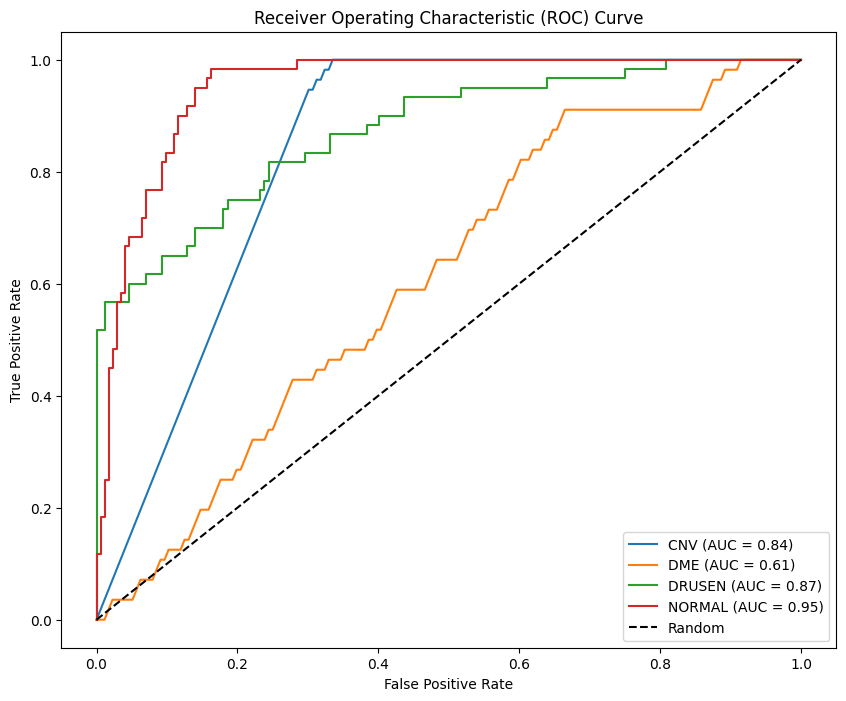

In [39]:
# plot a ROC Curve 
class_names = test_dataset.classes

plt.figure(figsize=(10, 8))
for i in range(config.num_classes):
    fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
roc_save_path = os.path.join('results/', "roc_curves.png")
plt.savefig(roc_save_path)
plt.show()


Generating Precision-Recall curves...


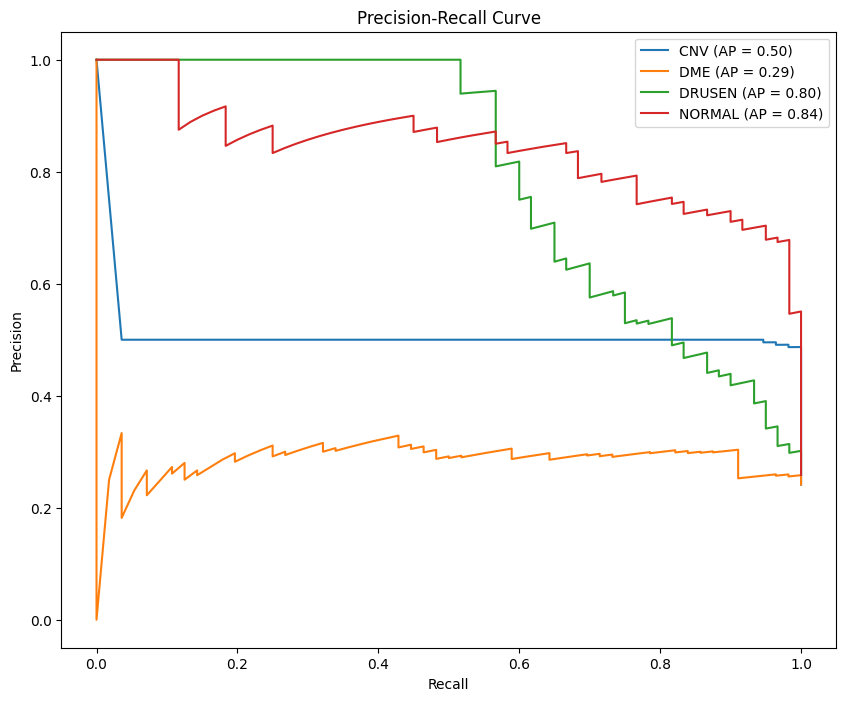

In [42]:
# Precision-Recall Curve
print("\nGenerating Precision-Recall curves...")
plt.figure(figsize=(10, 8))
all_labels_binarized = label_binarize(all_labels, classes=list(range(config.num_classes)))
for i in range(config.num_classes):
    precision, recall, _ = precision_recall_curve(all_labels_binarized[:, i], all_probs[:, i])
    average_precision = average_precision_score(all_labels_binarized[:, i], all_probs[:, i])
    plt.plot(recall, precision, label=f'{class_names[i]} (AP = {average_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
pr_save_path = os.path.join(output, "pr_curves.png")
plt.savefig(pr_save_path)
plt.show()
